## Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [4]:
preprocess_df = pd.read_csv('../data/preprocessing_data.csv')

## Feature Selection

In [5]:
X = preprocess_df.drop(columns = ['customer_id','location','payment_plan','payment_method','num_playlists_created','churned'])
y = preprocess_df['churned']

## Training set / Validation set / Test set

In [6]:
# 데이터를 70% 훈련 세트, 30% 임시 세트로 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# 임시 세트를 다시 50%로 나누어 15% 검증 세트, 15% 테스트 세트로 나누기
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

## MLP Model

- 모델 정의

In [8]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])

- 모델 컴파일

In [9]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  
              metrics=['accuracy'])

- 콜백 정의

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

- 모델 학습

In [11]:
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks = [early_stopping, model_checkpoint])

Epoch 1/100
2735/2735 [==============================] - 3s 917us/step - loss: 1.8711 - accuracy: 0.5069 - val_loss: 0.6929 - val_accuracy: 0.5112
Epoch 2/100
2735/2735 [==============================] - 2s 868us/step - loss: 0.6961 - accuracy: 0.5128 - val_loss: 0.6929 - val_accuracy: 0.5112
Epoch 3/100
2735/2735 [==============================] - 2s 858us/step - loss: 0.6940 - accuracy: 0.5137 - val_loss: 0.6929 - val_accuracy: 0.5112
Epoch 4/100
2735/2735 [==============================] - 2s 890us/step - loss: 0.6932 - accuracy: 0.5138 - val_loss: 0.6926 - val_accuracy: 0.5112
Epoch 5/100
2735/2735 [==============================] - 2s 878us/step - loss: 0.6925 - accuracy: 0.5140 - val_loss: 0.6916 - val_accuracy: 0.5112
Epoch 6/100
2735/2735 [==============================] - 2s 865us/step - loss: 0.6914 - accuracy: 0.5139 - val_loss: 0.6903 - val_accuracy: 0.5112
Epoch 7/100
2735/2735 [==============================] - 2s 878us/step - loss: 0.6906 - accuracy: 0.5139 - val_loss: 0

- 테스트 세트 평가

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

586/586 [==============================] - 0s 510us/step - loss: 0.3834 - accuracy: 0.8253
Test Accuracy: 0.8252800107002258


- 예측

In [13]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

586/586 [==============================] - 0s 449us/step


- 성능 평가

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("AUC: {:.2f}".format(roc_auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUC: 0.92
Precision: 0.85
Recall: 0.80
F1 Score: 0.82

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.85      0.83      9132
         1.0       0.85      0.80      0.82      9618

    accuracy                           0.83     18750
   macro avg       0.83      0.83      0.83     18750
weighted avg       0.83      0.83      0.83     18750



- Confusion Matrix 시각화

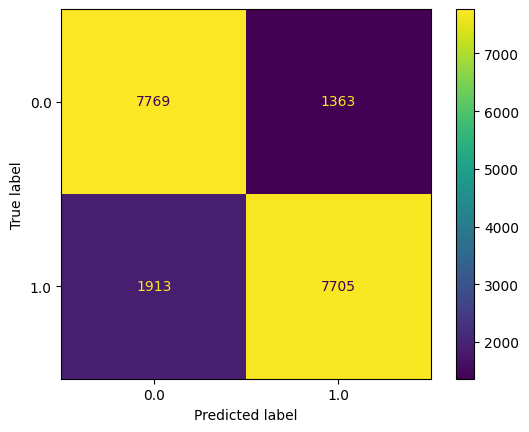

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

- ROC Curve 시각화

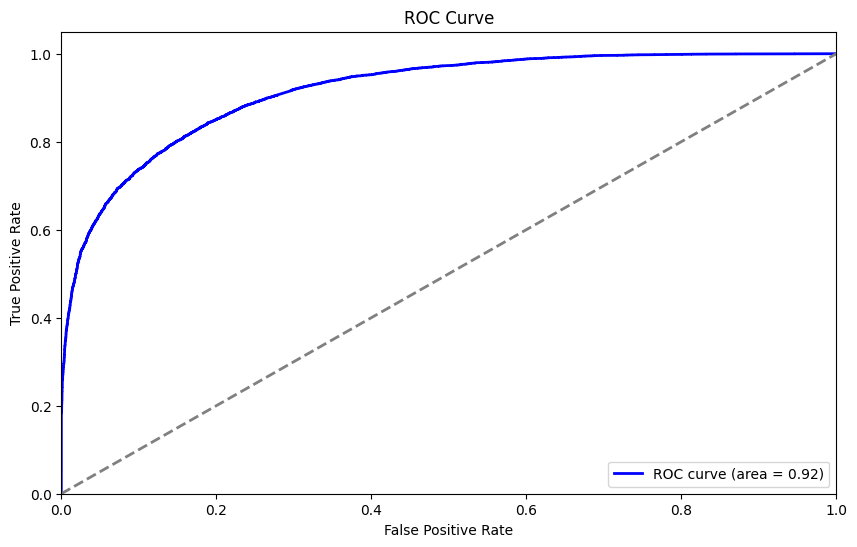

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()